In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from shapely.geometry import Point
pd.options.display.max_columns = 25

In [2]:
turistas = pd.read_csv("2073.csv",sep=";")
turistas["year"] = turistas["Periodo"].apply(lambda x: x[:4])
turistas["NAMEUNIT"] = turistas["Provincias con mayor número de pernoctaciones"].apply(lambda x: " ".join(x.split(" ")[1:]))
turistas["Total"] = turistas.Total.fillna(0).astype(int)

name_fix = {"Alicante/Alacant":"Alacant/Alicante",
            "Balears, Illes":"Illes Balears",
            "Castellón/Castelló":"Castelló/Castellón",
            "Coruña, A":"A Coruña",
            "Rioja, La":"La Rioja",
            "Valencia/València":"València/Valencia"}
turistas["NAMEUNIT"] = turistas["NAMEUNIT"].apply(lambda x: name_fix[x] if x in name_fix else x)

In [3]:
tursitas_extranjero = turistas[turistas["Residencia"] == "Residentes en el Extranjero"].copy()
turistas_locales = turistas[turistas["Residencia"] != "Residentes en el Extranjero"].copy()

tursitas_extranjero.rename(columns={"Total":"total_extranjeros"},inplace=True)
turistas_locales.rename(columns={"Total":"total_locales"},inplace=True)

In [4]:
tursitas_extranjero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21900 entries, 219 to 43799
Data columns (total 7 columns):
 #   Column                                         Non-Null Count  Dtype 
---  ------                                         --------------  ----- 
 0   Provincias con mayor número de pernoctaciones  21900 non-null  object
 1   Viajeros y pernoctaciones                      21900 non-null  object
 2   Residencia                                     21900 non-null  object
 3   Periodo                                        21900 non-null  object
 4   total_extranjeros                              21900 non-null  int64 
 5   year                                           21900 non-null  object
 6   NAMEUNIT                                       21900 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.3+ MB


In [5]:
turistas_ratio = turistas_locales.merge(tursitas_extranjero[["NAMEUNIT","Periodo","Viajeros y pernoctaciones","total_extranjeros"]],on=["NAMEUNIT","Periodo","Viajeros y pernoctaciones"])

In [6]:
turistas_ratio["extranjerosratio"] = turistas_ratio["total_extranjeros"] / (turistas_ratio["total_extranjeros"] + turistas_ratio["total_locales"])
turistas_ratio["localesratio"] = 1 - turistas_ratio["extranjerosratio"]

In [7]:
turistas_ratio.describe()

,total_locales,total_extranjeros,extranjerosratio,localesratio
count,21900.000000,21900.000000,21554.000000,21554.000000
mean,7762.759087,1966.190868,0.142813,0.857187
std,12363.411999,8293.798436,0.186333,0.186333
min,0.000000,0.000000,0.000000,0.045166
25%,2240.000000,110.000000,0.029940,0.831979
50%,4516.000000,389.000000,0.072839,0.927161
75%,9093.000000,1183.000000,0.168021,0.970060
max,294431.000000,193026.000000,0.954834,1.000000


In [8]:
viajeros = turistas[turistas["Viajeros y pernoctaciones"] == "Viajero"].groupby(["year","NAMEUNIT"]).sum().reset_index()
pernoctaciones = turistas[turistas["Viajeros y pernoctaciones"] == "Pernoctaciones"].groupby(["year","NAMEUNIT"]).sum().reset_index()

In [9]:
provincias = gpd.read_file('lineas_limite.zip!SHP_ETRS89/recintos_provinciales_inspire_peninbal_etrs89')
#INSPIREID', 'COUNTRY', 'NATLEV', 'NATLEVNAME', 'NATCODE', 'NAMEUNIT', 'CODNUT1', 'CODNUT2', 'CODNUT3', 'geometry'
provincias = provincias.to_crs("+proj=cea EPSG:2062")
provincias['area'] = round(provincias.area/1000000,0)
provincias['latitud'] = provincias.centroid.map(lambda p: p.y)
#Mapa de coropletas: mapa temÃ¡tico con las Ã¡reas sombreadas de diferentes colores en funciÃ³n del valor de una columna
provincias = provincias.to_crs(crs=3395)
#LÃ­mites de las provincias

In [10]:
provincias.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   INSPIREID   51 non-null     object  
 1   COUNTRY     51 non-null     object  
 2   NATLEV      51 non-null     object  
 3   NATLEVNAME  51 non-null     object  
 4   NATCODE     51 non-null     object  
 5   NAMEUNIT    51 non-null     object  
 6   CODNUT1     51 non-null     object  
 7   CODNUT2     51 non-null     object  
 8   CODNUT3     0 non-null      float64 
 9   geometry    51 non-null     geometry
 10  area        51 non-null     float64 
 11  latitud     51 non-null     float64 
dtypes: float64(3), geometry(1), object(8)
memory usage: 4.9+ KB


In [11]:
provincias_viajeros = provincias.merge(right=viajeros,on="NAMEUNIT")

In [12]:
provincias_viajeros.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 18 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   INSPIREID                                      912 non-null    object  
 1   COUNTRY                                        912 non-null    object  
 2   NATLEV                                         912 non-null    object  
 3   NATLEVNAME                                     912 non-null    object  
 4   NATCODE                                        912 non-null    object  
 5   NAMEUNIT                                       912 non-null    object  
 6   CODNUT1                                        912 non-null    object  
 7   CODNUT2                                        912 non-null    object  
 8   CODNUT3                                        0 non-null      float64 
 9   geometry                           

(-1133284.8865093752, 579624.0892436153, 4188128.9565306343, 5482619.275105776)

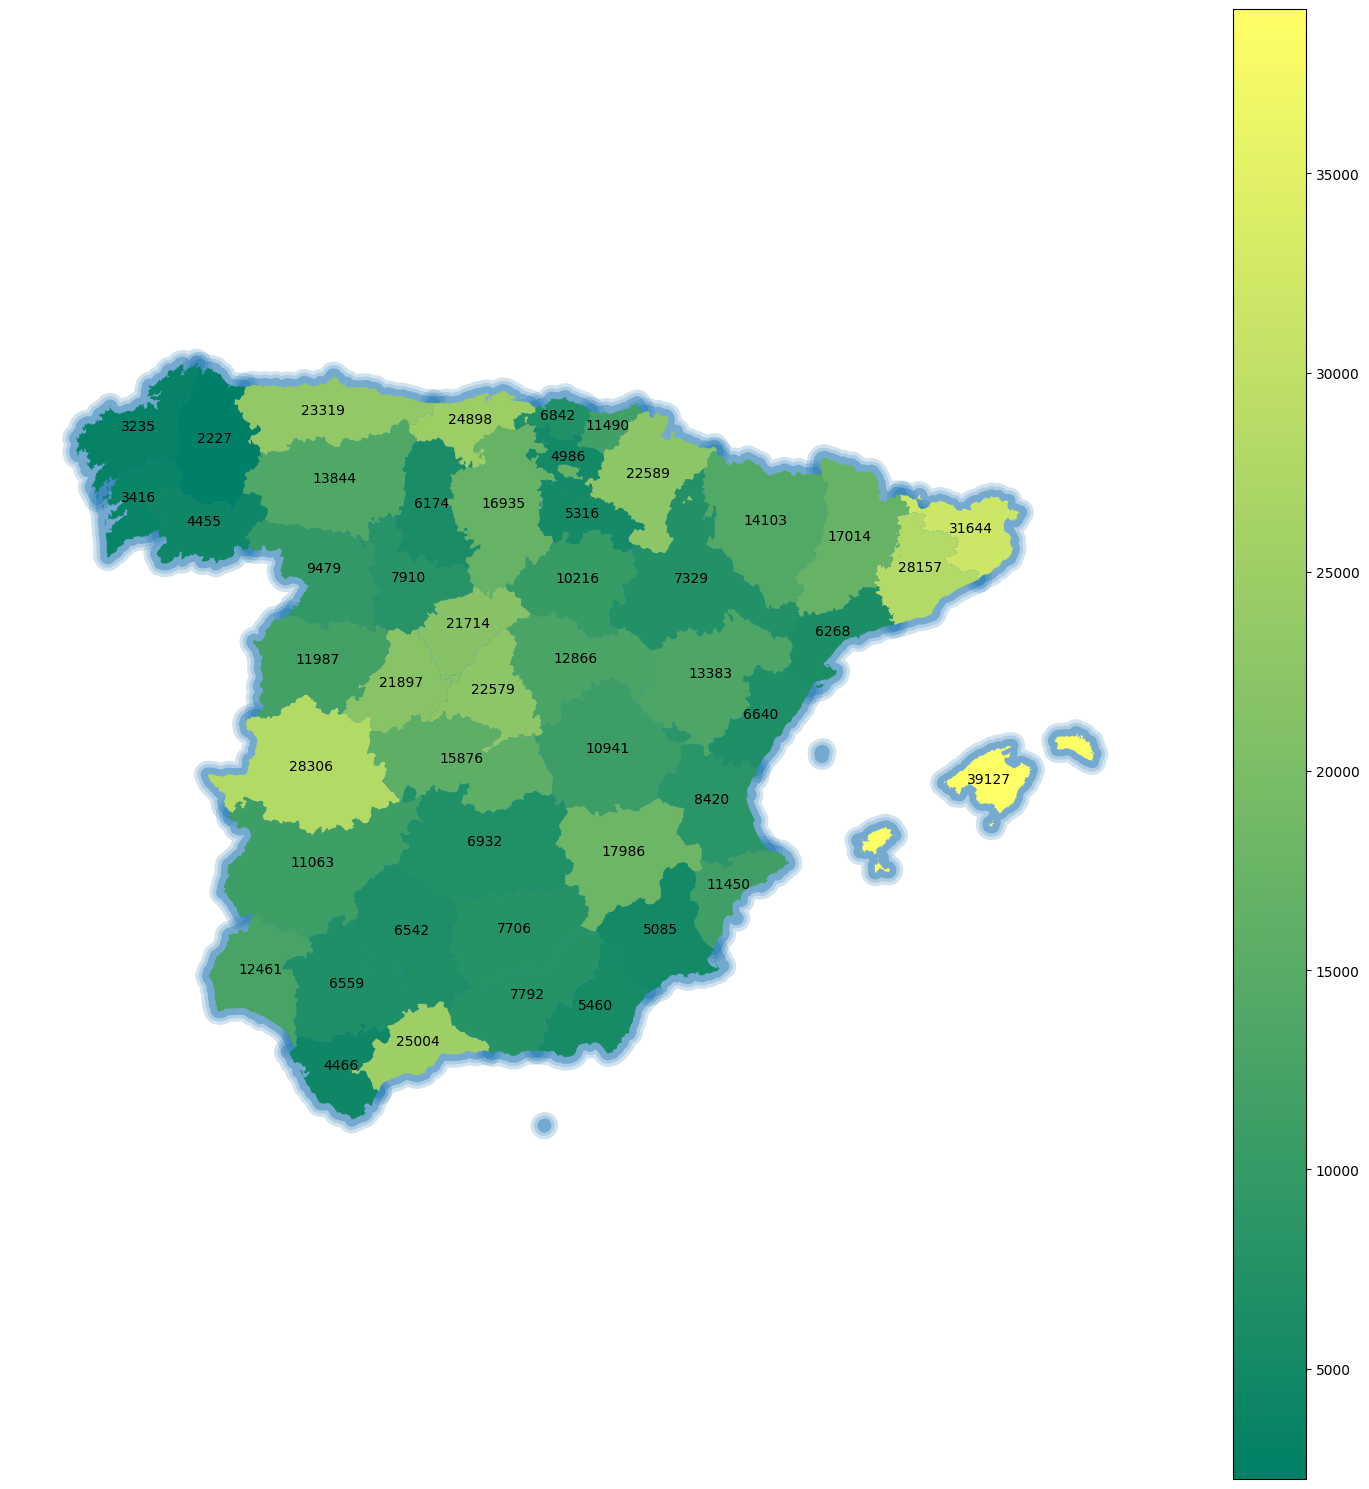

In [13]:
ax = provincias_viajeros[provincias_viajeros["year"] == "2023"].buffer(20000).plot(figsize=(15,15),alpha=0.2)
ax = provincias_viajeros[provincias_viajeros["year"] == "2023"].buffer(15000).plot(ax = ax,figsize=(15,15),alpha=0.2)
ax = provincias_viajeros[provincias_viajeros["year"] == "2023"].buffer(10000).plot(ax = ax,figsize=(15,15),alpha=0.4)
provincias_viajeros[provincias_viajeros["year"] == "2023"].plot(ax = ax,column="Total",legend=True,cmap="summer")
provincias_viajeros[provincias_viajeros["year"] == "2023"].apply(lambda x: ax.annotate(text=(x.Total),
    xy=x.geometry.centroid.coords[0], ha='center',
    fontsize=10),axis=1)
plt.tight_layout()
plt.axis("off")


In [20]:
viajeros_ratio = turistas_ratio[turistas_ratio["Viajeros y pernoctaciones"] == "Viajero"].groupby(["year","NAMEUNIT"]).mean(numeric_only=True).reset_index()
pernoctaciones_ratio = turistas_ratio[turistas_ratio["Viajeros y pernoctaciones"] == "Pernoctaciones"].groupby(["year","NAMEUNIT"]).mean(numeric_only=True).reset_index()

In [21]:
provincias_viajeros_ratio = provincias.merge(right=viajeros_ratio,on="NAMEUNIT")

In [22]:
provincias_viajeros_ratio.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   INSPIREID          912 non-null    object  
 1   COUNTRY            912 non-null    object  
 2   NATLEV             912 non-null    object  
 3   NATLEVNAME         912 non-null    object  
 4   NATCODE            912 non-null    object  
 5   NAMEUNIT           912 non-null    object  
 6   CODNUT1            912 non-null    object  
 7   CODNUT2            912 non-null    object  
 8   CODNUT3            0 non-null      float64 
 9   geometry           912 non-null    geometry
 10  area               912 non-null    float64 
 11  latitud            912 non-null    float64 
 12  year               912 non-null    object  
 13  total_locales      912 non-null    float64 
 14  total_extranjeros  912 non-null    float64 
 15  extranjerosratio   911 non-null    float64 
 16  

(-1133284.8865093752, 579624.0892436153, 4188128.9565306343, 5482619.275105776)

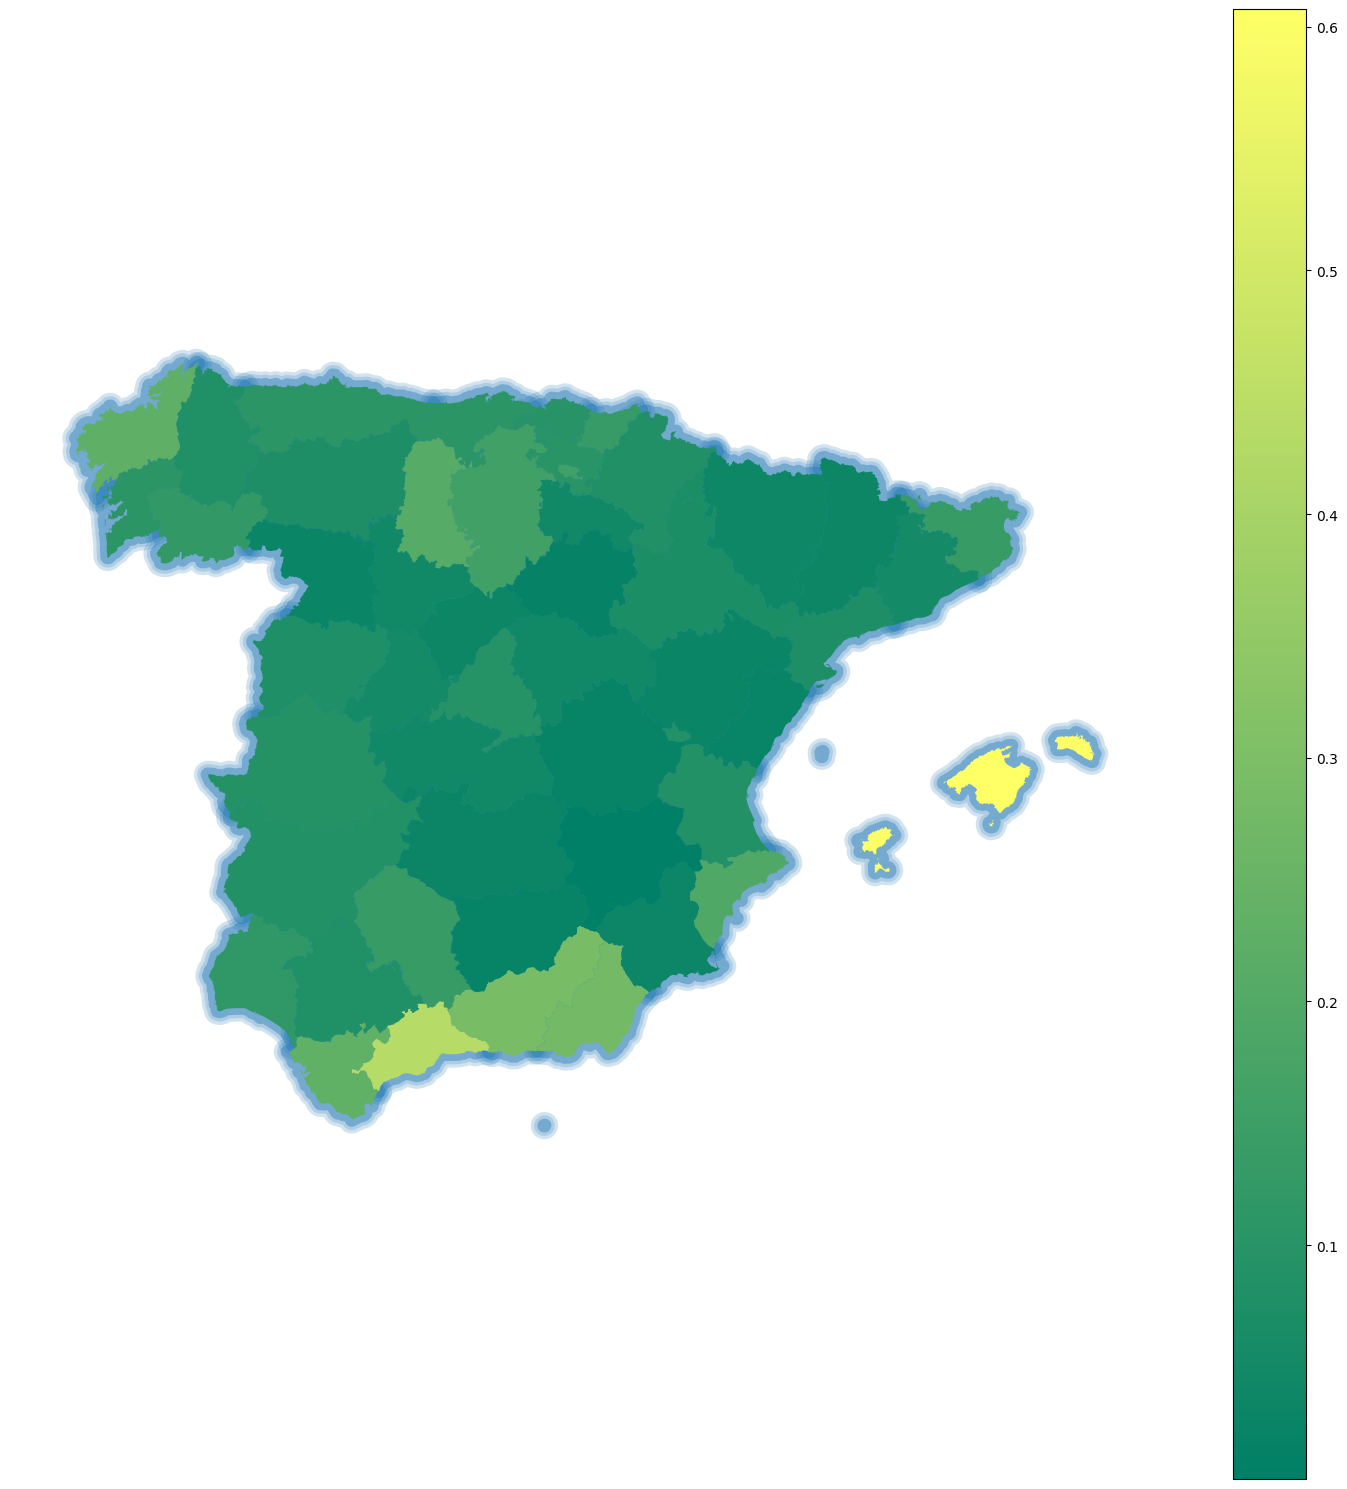

In [23]:
ax = provincias_viajeros_ratio[provincias_viajeros_ratio["year"] == "2023"].buffer(20000).plot(figsize=(15,15),alpha=0.2)
ax = provincias_viajeros_ratio[provincias_viajeros_ratio["year"] == "2023"].buffer(15000).plot(ax = ax,figsize=(15,15),alpha=0.2)
ax = provincias_viajeros_ratio[provincias_viajeros_ratio["year"] == "2023"].buffer(10000).plot(ax = ax,figsize=(15,15),alpha=0.4)
provincias_viajeros_ratio[provincias_viajeros_ratio["year"] == "2023"].plot(ax = ax,column="extranjerosratio",legend=True,cmap="summer")
"""provincias_viajeros_ratio[provincias_viajeros_ratio["year"] == "2023"].apply(lambda x: ax.annotate(text=(x.extranjeros2localesratio.round(2)),
    xy=x.geometry.centroid.coords[0], ha='center',
    fontsize=10),axis=1)"""
plt.tight_layout()
plt.axis("off")